### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D

### Read the ATN profiles 

In [2]:
gmm = pd.read_csv("../gmm/final_profiles_gmm.csv", index_col=0)
kmeans = pd.read_csv("../k_means/final_profiles_kmeans.csv", index_col=0)
tertile = pd.read_csv("../tertile/final_profiles_tertile.csv", index_col=0)
roc = pd.read_csv("../roc/final_profiles_roc.csv", index_col=0)
mean_sd = pd.read_csv("../mean_std/final_profiles_mean_std.csv", index_col=0)

In [3]:
patients_ = dict(gmm.sum(axis=1))

### Data preparation

In [4]:
gmm['method'] = 'gmm'
kmeans['method'] = 'kmeans'
tertile['method'] = 'tertile'
roc['method'] = 'roc'
mean_sd['method'] = 'mean_sd'

In [5]:
print(roc.index.difference(tertile.index))
roc.index # not all methods were applied for all cohorts

Index([], dtype='object')


Index(['ADNI', 'EPAD', 'NACC', 'EMIF', 'JADNI'], dtype='object')

In [6]:
profiles_all = pd.concat([gmm, kmeans, tertile, roc, mean_sd])

In [7]:
profiles_all.loc['ADNI']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+,method
ADNI,275,28,5,2,25,443,12,227,gmm
ADNI,256,49,14,0,18,305,16,359,kmeans
ADNI,265,160,10,3,33,148,3,395,tertile
ADNI,304,147,8,6,34,180,1,337,roc
ADNI,813,154,20,22,0,7,0,1,mean_sd


### Stackedplot

In [8]:
profiles_all.replace({'mean_sd': 'Mean ±2 SD', 'gmm': 'GMM', 
                              'roc': 'ROC', 'kmeans': 'K-Means', 
                              'tertile': 'Tertile'}, inplace=True)

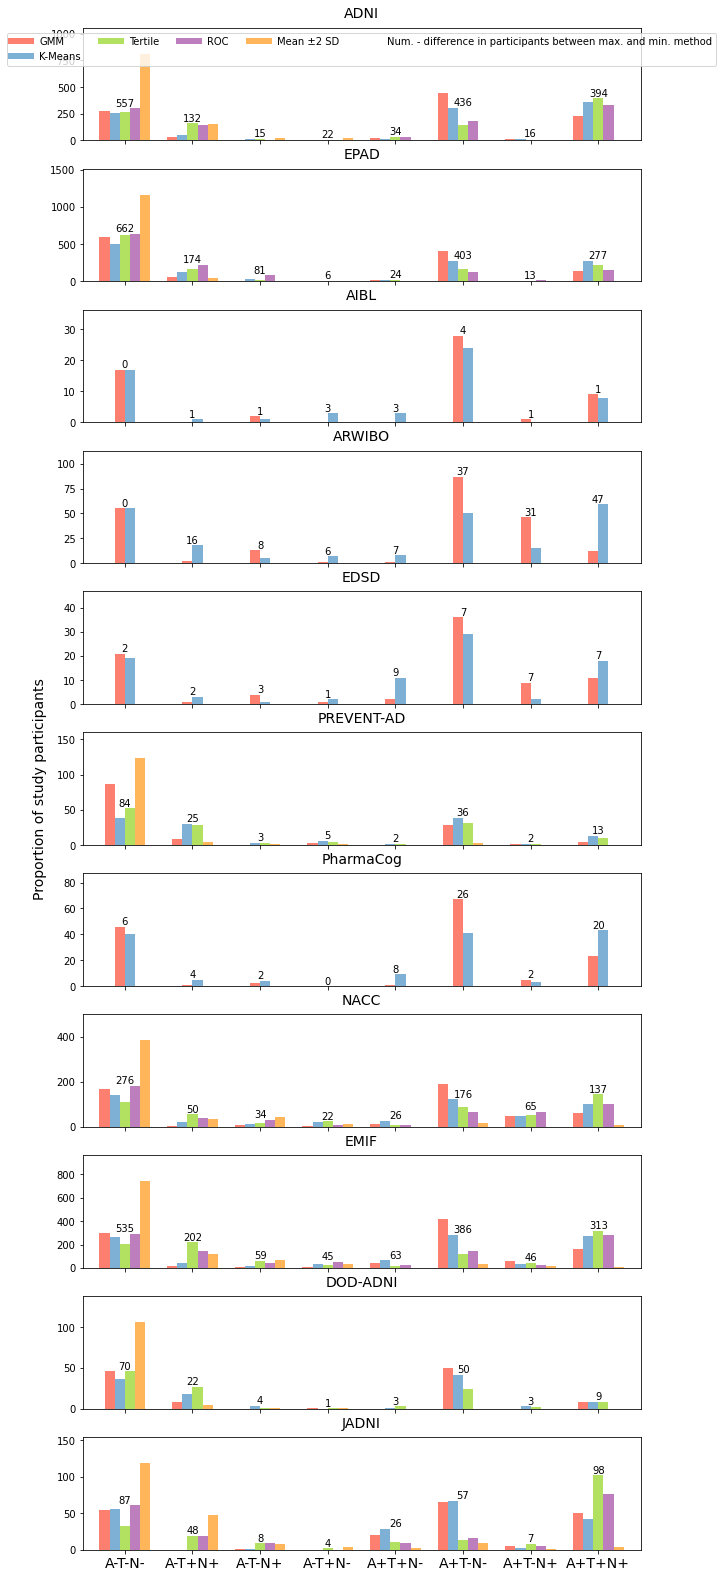

In [10]:
fig, axes = plt.subplots(11, sharex=True, figsize=(10, 28))
fig.subplots_adjust(hspace=0.25)
width = {'2': .3, '4': 0.6, '5': .75}
# colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']
# colors_ = ['#483838', '#42855B', '#90B77D', '#D2D79F', ]
# colors_ = ['#C8C6A7', '#92967D', '#BBBBBB', '#6E7C7C', '#435560']
# colors_ = ['#ff7f0e', '#2ca02c', '#7f7f7f', '#ff9896', '#c49c94']
# colors_ = ['#89CFFD', '#008ac5', '#0069c0', '#0045a5', '#0b1d78']
colors_ = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]
colors_dict = {method: color for color, method in zip(colors_, profiles_all.method.unique())}

# colors_ = sns.color_palette('Paired', n_colors=5)
# colors_ = ['#EC9CD3', '#FF7F3F', '#FBDF07', '#89CFFD', '#6ECB63']

for i, coh in enumerate(profiles_all.index.unique()):
    current_cohort_ = profiles_all.loc[coh].copy()
    current_cohort_['Cohort'] = coh
    current_cohort_.rename(columns={'method': 'Method'}, inplace=True)
    current_cohort_.set_index('Method', inplace=True)
    current_cohort_ = current_cohort_.transpose()
#     print(coh)
    for ind in current_cohort_.index[:-1]:
        current_cohort_.loc[ind, 'delta'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))
#         current_cohort_.loc[ind, 'error'] = (max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2
#         current_cohort_.loc[ind, 'middle'] = ((max(current_cohort_.loc[ind]) - min(current_cohort_.loc[ind]))/2) + min(current_cohort_.loc[ind])
    
    max_limit = current_cohort_.iloc[:-1].to_numpy().max()
#     print(max_limit)
    
    if i!=0:
        
        for x_pos, indd in enumerate(current_cohort_.index[:-1]):            
#             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
#                              linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
            if len(current_cohort_.columns[:-1])==5:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])
                
                axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            
            elif len(current_cohort_.columns[:-1])==2:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[:]])
                axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
                
            else:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:3]])
                axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')

    
        current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, legend=False, 
                                       width=width[str(len(current_cohort_.columns[:-1]))])
        axes[i].set_title(coh, fontsize=14, pad=10)
        axes[i].tick_params(rotation=0, axis="x", which='major', labelsize=14)
        axes[i].set_ylim([0, max_limit+(max_limit*0.3)])
#         axes[i].text(x_pos, 1.10*(bar[0] + bar[1]), max_number[coh][x_pos], ha='center', va='bottom')

    else:
        
        for x_pos, indd in enumerate(current_cohort_.index[:-1]):
#             axes[i].errorbar(y=current_cohort_.loc[indd, 'middle'], x=x_pos, yerr=current_cohort_.loc[indd, 'error'], capsize=caps, marker="", 
#                          linestyle="", color='black', markersize=markersize, capthick=capthick, lw=lw)
        
            if len(current_cohort_.columns[:-1])==5:
                position_ = max(current_cohort_.loc[indd, current_cohort_.columns[1:4]])
                axes[i].text(x_pos, position_, int(current_cohort_.loc[indd, 'delta']), ha='center', va='bottom')
            

        current_cohort_[current_cohort_.columns[:-1]].iloc[:-1].plot(kind='bar', ax=axes[i], color=colors_dict, 
                                                   width=width[str(len(current_cohort_.columns[:-1]))])
        axes[i].set_title(coh, fontsize=14, pad=10)
#         handles, labels = axes[i].get_legend_handles_labels()
#         print(testing.get_legend_handles_labels()[1])
#         axes[i].legend(loc='upper center', ncol=5)
        legend_labels = colors_dict.copy()
        legend_labels['Num. - difference in participants between max. and min. method'] = 'white'
        legend_elements = ([Line2D([0], [0], lw=6, color=legend_labels[n], label=n) for n in legend_labels])
#         print(legend_elements)
#         print(legend_labels)
        axes[i].legend(handles=legend_elements, loc='upper center', ncol=5)
        
#         patches = list()
#         for n in colors_dict:
#             patches.append(Line2D([0], [0], lw=5, color=colors_dict[n], label=n))
            
#         text_ = 'Num. - difference in participants between max. and min. method'
#         patches.append(Line2D([0], [0], color='white'))
#         extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        

#         print(handles, labels)
#         extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
#         label_order = ['GMM', 'K-Means', 'ROC', 'Mean ±2 SD', 'Tertile', legend_labels]
#         axes[i].legend(labels=legend_elements, handles=legend_elements, loc='upper center', ncol=5)
#         axes[i].add_artist(axes[i].legend(handles=patches, loc='center', ncol=1))
#         axes[i].add_artist(axes[i].legend(handles=handles, labels=labels, loc='upper center', ncol=5))
        
#         
            
#         axes[i].legend(patches, fontsize=10, ncol=5, markerscale=1.5, loc='upper center')
        axes[i].set_ylim([0, max_limit+(max_limit*0.3)])
        
    axes[5].set_ylabel('Proportion of study participants', fontsize=14, labelpad=10)



plt.savefig("bar_plot_atn_happycolor5.png", dpi=300, bbox_inches='tight')